# бейзлайны:

In [1]:
import pandas as pd
import numpy as np
import torch
import pickle

from metrics import ( 
    calculate_grouped_ndcg_random, 
    calculate_grouped_ndcg_sum_popularity,
    calculate_grouped_ndcg_with_embeddings,
    calculate_grouped_ndcg_for_bert4rec_output
)

In [2]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('movielens_1m_dataset/ratings.dat', sep='::', header=None, names=rnames, engine='python', encoding='ISO-8859-1')

In [3]:
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [4]:
ratings.sort_values(["user_id", "timestamp"], inplace=True)

ratings = ratings[["user_id", "movie_id", "rating"]]

ratings.reset_index(drop=True, inplace=True)

ratings = ratings.astype(int)

ratings

,user_id,movie_id,rating
0,1,3186,4
1,1,1270,5
2,1,1721,4
3,1,1022,5
4,1,2340,3
...,...,...,...
1000204,6040,2917,4
1000205,6040,1921,4
1000206,6040,1784,3
1000207,6040,161,3


In [5]:
ratings.user_id.nunique(), ratings.user_id.min(), ratings.user_id.max()

(6040, 1, 6040)

In [6]:
ratings.movie_id.nunique(), ratings.movie_id.min(), ratings.movie_id.max()

(3706, 1, 3952)

In [7]:
ratings.rating = 1

ratings

,user_id,movie_id,rating
0,1,3186,1
1,1,1270,1
2,1,1721,1
3,1,1022,1
4,1,2340,1
...,...,...,...
1000204,6040,2917,1
1000205,6040,1921,1
1000206,6040,1784,1
1000207,6040,161,1


In [8]:
# ratings = ratings[ratings.groupby("movie_id")['user_id'].transform('count') >= 5]
# дабы подстроиться под берт. потом вернем
ratings = ratings[ratings.groupby("user_id")['movie_id'].transform('count') >= 5]
ratings = ratings[ratings.groupby("movie_id")['user_id'].transform('count') >= 0]

ratings.reset_index(drop=True, inplace=True)

ratings

,user_id,movie_id,rating
0,1,3186,1
1,1,1270,1
2,1,1721,1
3,1,1022,1
4,1,2340,1
...,...,...,...
1000204,6040,2917,1
1000205,6040,1921,1
1000206,6040,1784,1
1000207,6040,161,1


In [9]:
print("statistics:", ratings.user_id.nunique(), ratings.movie_id.nunique())

statistics: 6040 3706


In [10]:
def create_index_mapping(df):
    """
    Создает словарь, отображающий айдишники юзеров и айтемов в
    небольшие различные числа (соответствующие индексам в enumerate)
    Зачем это нужно: implicit ALS хочет спарс матрицу для обучения, а размер scipy спарс
    матрицы зависит от максимального значения айдишника. Применение такого отображения к данным
    позволит работать с матрицами значительно меньших размеров.
    Parameters
        df: датасет, с колонок которого создаются словари
    Returns
        u2ix, i2ix: вышеописанные словари
    """
    u2ix = {user_id: i for i, user_id in enumerate(df.user_id.unique())}
    i2ix = {item_id: i for i, item_id in enumerate(df.movie_id.unique())}
    return u2ix, i2ix

def apply_index_mapping(df, u2ix, i2ix) -> pd.DataFrame:
    """
    Применяет вышеописанные словари к колонкам "user_id" и "movie_id".
    Parameters
        df: датасет, к которому применяется маппинг по словарям
        u2ix: словарь "user_id": "небольшое число"
        i2ix: словарь "movie_id": "небольшое число"
    Returns
        df: датасет с измененными (согласно u2ix и i2ix) значениями в колонках
    """
    df.user_id = df.user_id.map(lambda x: u2ix[x])
    df.movie_id = df.movie_id.map(lambda x: i2ix[x])
    return df

u2ix, i2ix = create_index_mapping(ratings)
ratings = apply_index_mapping(ratings, u2ix, i2ix)

In [11]:
ratings.user_id.min(), ratings.user_id.max()

(0, 6039)

In [12]:
ratings.movie_id.min(), ratings.movie_id.max()

(0, 3705)

leave-last-out:

In [13]:
test = ratings.groupby("user_id").tail(1)

test

,user_id,movie_id,rating
52,0,52,1
181,1,174,1
232,2,207,1
253,3,88,1
451,4,384,1
...,...,...,...
999522,6035,927,1
999724,6036,684,1
999744,6037,1587,1
999867,6038,579,1


In [14]:
train_and_val = ratings.drop(test.index, axis=0)

train_and_val

,user_id,movie_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
1000203,6039,1097,1
1000204,6039,1248,1
1000205,6039,370,1
1000206,6039,89,1


In [15]:
val = train_and_val.groupby("user_id").tail(1)

val

,user_id,movie_id,rating
51,0,51,1
180,1,173,1
231,2,206,1
252,3,217,1
450,4,383,1
...,...,...,...
999521,6035,3356,1
999723,6036,244,1
999743,6037,252,1
999866,6038,562,1


In [16]:
train = train_and_val.drop(val.index, axis=0)

train

,user_id,movie_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
1000202,6039,180,1
1000203,6039,1097,1
1000204,6039,1248,1
1000205,6039,370,1


In [17]:
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train_and_val.reset_index(drop=True, inplace=True) # нужно только для бейзлайнов и алс, мы там ниче не смотрим на val и не тюним

In [18]:
# так, берту не нужно время, ток порядок
train_dict = dict(train.groupby('user_id').apply(lambda d: list(d['movie_id'])))
val_dict = dict(val.groupby('user_id').apply(lambda d: list(d['movie_id'])))
test_dict = dict(test.groupby('user_id').apply(lambda d: list(d['movie_id'])))

In [19]:
dataset_for_bert4rec = {'train': train_dict,
                       'val': val_dict,
                       'test': test_dict,
                       'umap': u2ix,
                       'smap': i2ix}

In [20]:
# import pickle

# with open('prepared_dataset/dataset_for_bert4rec.pickle', 'wb') as handle:
#     pickle.dump(dataset_for_bert4rec, handle, protocol=pickle.HIGHEST_PROTOCOL)

... продолжаем:

In [21]:
train_and_val

,user_id,movie_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
994164,6039,1097,1
994165,6039,1248,1
994166,6039,370,1
994167,6039,89,1


In [22]:
test

,user_id,movie_id,rating
0,0,52,1
1,1,174,1
2,2,207,1
3,3,88,1
4,4,384,1
...,...,...,...
6035,6035,927,1
6036,6036,684,1
6037,6037,1587,1
6038,6038,579,1


In [23]:
user_positively_interacted_with = ratings.groupby('user_id')['movie_id'].apply(set).to_dict()

In [24]:
assert len(user_positively_interacted_with[1]) == len(train_and_val[train_and_val.user_id == 1]) + 1

In [25]:
item_count = ratings["movie_id"].value_counts().to_dict()
item_probabilities = {k: v / sum([x for x in item_count.values()]) for k, v in item_count.items()}

In [26]:
item_probabilities[62]

0.003427283697707179

In [27]:
item_probabilities[731]

0.00035592561154718663

In [28]:
import numpy as np
from numpy.random import choice

negative_samples = dict()
test_rows = []

for _, row in test.iterrows():
    test_interactions = [(row["user_id"], row["movie_id"], row["rating"],)]
    
    np.random.seed(row["user_id"])
    negative_sampled_interactions = list(choice(list(item_probabilities.keys()), 800, replace=False, p=list(item_probabilities.values())))
    negative_sampled_interactions = [x for x in negative_sampled_interactions if x not in user_positively_interacted_with[row["user_id"]]]
    negative_sampled_interactions = negative_sampled_interactions[:100]
    
    # потом, когда будем делать берт, будем ссылаться на сгенерированные здесь негативы:
    negative_samples[row["user_id"]] = negative_sampled_interactions

    test_interactions.extend([(row["user_id"], x, 0,) for x in negative_sampled_interactions])
    
    test_rows.extend(test_interactions)
    
test_rows[:10]

[(0, 52, 1),
 (0, 1068, 0),
 (0, 731, 0),
 (0, 1026, 0),
 (0, 314, 0),
 (0, 1148, 0),
 (0, 1008, 0),
 (0, 1030, 0),
 (0, 1513, 0),
 (0, 2575, 0)]

In [29]:
negative_samples[0][:9]

[1068, 731, 1026, 314, 1148, 1008, 1030, 1513, 2575]

In [30]:
neg_sampled_test = pd.DataFrame(test_rows, columns=["user_id", "movie_id", "rating"])

neg_sampled_test

,user_id,movie_id,rating
0,0,52,1
1,0,1068,0
2,0,731,0
3,0,1026,0
4,0,314,0
...,...,...,...
610035,6039,442,0
610036,6039,581,0
610037,6039,147,0
610038,6039,1327,0


### random baseline:

In [29]:
ndcgresults = []
for i in range(10):
    ndcg_value = calculate_grouped_ndcg_random(train_and_val, neg_sampled_test, 10, i)
    
    ndcgresults.append(ndcg_value)
    
np.mean(ndcgresults), np.std(ndcgresults)

(0.04438110400529842, 0.001780072420999918)

### pop baseline:

In [30]:
calculate_grouped_ndcg_sum_popularity(train_and_val, neg_sampled_test, 10)

0.06391453558404456

### iALS baseline:

In [31]:
import scipy.sparse as sparse


def create_sparse_matrix(df: pd.DataFrame) -> sparse.csr_matrix:
    """
    Делает разреженную матрицу из пандас датафрейма. Нужно для
    обучения implicit.als.AlternatingLeastSquares.
    Parameters
        df (pd.DataFrame): датасет
    Returns
        csr (sparse.csr_matrix): разреженная матрица
    """
    csr = sparse.csr_matrix((df.rating, (df.user_id, df.movie_id)))
    return csr

sparse_train_and_val = create_sparse_matrix(train_and_val)

In [32]:
import implicit

In [33]:
iALS = implicit.als.AlternatingLeastSquares(factors=256, iterations=150)

C:\Users\atama\anaconda3\envs\conda_bert4rec\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [34]:
iALS.fit(sparse_train_and_val)

  0%|          | 0/150 [00:00<?, ?it/s]

In [35]:
calculate_grouped_ndcg_with_embeddings(neg_sampled_test, iALS, 10)

0.2209271961839956

In [36]:
BPRMF = implicit.bpr.BayesianPersonalizedRanking(factors=256, iterations=150)

In [37]:
BPRMF.fit(sparse_train_and_val)

  0%|          | 0/150 [00:00<?, ?it/s]

In [38]:
calculate_grouped_ndcg_with_embeddings(neg_sampled_test, BPRMF, 10)

0.2718568152928149

# начинаем берт4рек:

In [31]:
import argparse

import pandas as pd
import pickle
import random
import torch

from tqdm import trange
from collections import Counter

import numpy as np
from numpy.random import choice

In [32]:
# fix argparse in ipython
import sys
sys.argv = ['']

In [33]:
from bert4rec_modules_and_configs.utils import *
from bert4rec_modules_and_configs.options import args

In [34]:
# то что сохранили

def read_data(prepared_data_path):
    with open(prepared_data_path, 'rb') as handle:
        dataset = pickle.load(handle)
    return dataset

In [35]:
data = read_data(args.prepared_data_path)

train_data = data['train']
val_data = data['val']
test_data = data['test']
umap = data['umap']
smap = data['smap']

In [36]:
# отслеживаем путь юзера с индексом 0 (оригинальный айди 1)
print(train_data[0])
print(val_data[0])
print(test_data[0])
print(umap[1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[51]
[52]
0


готовим трейн датасет и даталоадер:

In [37]:
class BertTrainDataset(torch.utils.data.Dataset):
    def __init__(self, u2seq, max_len, mask_prob, mask_token, num_items, rng):
        self.u2seq = u2seq
        self.users = sorted(self.u2seq.keys())  # дополнительный "надежный" (с заданным порядком) способ ходить по train_data, в отличие от хождения по train_data по ключу
        self.max_len = max_len
        self.mask_prob = mask_prob
        print("self.mask_prob", self.mask_prob)
        self.mask_token = mask_token
        print("self.mask_token", self.mask_token)
        self.num_items = num_items
        self.rng = rng

    def __len__(self):
        return len(self.users)

    def __getitem__(self, index):
        user = self.users[index]
        seq = self._getseq(user)

        tokens = []
        labels = []
        for s in seq: # касательно каждого s заполняем токен и лейбл
            prob = self.rng.random()  # сгенерили для конкретного s вероятность uniform, deterministic
            if prob < self.mask_prob:  # если prob меньше self.mask_prob == 0.15: TLDR С ВЕРОЯТНОСТЬЮ 80% ЗАПОЛНИМ ТОКЕН МАСКТОКЕНОМ, А НЕ ЭТИМ ITEM INDEX
                prob /= self.mask_prob  # то сильно бустим, затем...

                # if prob < 0.8:
                if prob < 0.99:
                    tokens.append(self.mask_token)  # если оч слабо то заполняем токен масктокеном - который max(item !INDEX!) + 1 или self.item_count + 1
                # if prob < 0.9:
                elif prob < 0.999:
                    tokens.append(self.rng.randint(1, self.num_items))  # если попал в маленькое окошко - то рандомно между 1 и self.item_count (== self.num_items) НАХУЯ?
                else:
                    tokens.append(s) # emergency(?) вариант, но лэйбл всё равно заполнится ненормальным значением - он заполнится ЭТИМ ITEM INDEX

                labels.append(s)
            else:
                tokens.append(s)
                labels.append(0)  # !!!ЭТО СТРАННО ВЕДЬ СУЩНОСТЬ S [0, MAX INDEX]!!!

        # в итоге каждому s присвоится либо (s, 0) если не замаскирован, либо (mask_token<под вопросом>, s). окей, для чего? !!!ЭТО СТРАННО ВЕДЬ СУЩНОСТЬ S [0, MAX INDEX]!!!

        # видимо max_len это не длина окна подпоследовательности из всей последовательности (если использование такой подпоследовательности ваще в этой реализации будет как-то фигурировать), а то, раньше чего мы 100% забываем
        tokens = tokens[-self.max_len:]
        labels = labels[-self.max_len:]
        # был 140 - стал 100
        # был 90 - стал 90

        # тупа паддинг, если изначальный seq был меньше max_len
        mask_len = self.max_len - len(tokens)

        # прилепляем нули слева. почему нули???? !!!ЭТО СТРАННО ВЕДЬ СУЩНОСТЬ S [0, MAX INDEX]!!!
        tokens = [0] * mask_len + tokens
        labels = [0] * mask_len + labels

        # лол ща попробуем маскировать с 10% вероятностью последний айтем
        prob = self.rng.random()
        if prob < 0.1:
            tokens[-1] = self.mask_token
            labels[-1] = seq[-1]

        # в итоге каждому s присвоится либо (s, 0) если не замаскирован, либо (mask_token<под вопросом><уже не под вопросом>, s) + в начале будут прилеплены нули, если не дотягивает до max_len, или иначе обрублено [-max_len:]. окей, для чего? !!!ЭТО СТРАННО ВЕДЬ СУЩНОСТЬ S [0, MAX INDEX]!!!
        # tokens    0   0   0   2969, 1574,   957,    1178,   <3707>, 1658,   <3707>, 1117
        # labels    0   0   0   0     0       0       0       2147    0       3177    0
        return torch.LongTensor(tokens), torch.LongTensor(labels)

        # КАК ЕЩЁ ЧАСТО ДЕЛАЕТСЯ И КАК ДЕЛАЛОСЬ В СТАТЬЕ: БЕРЕТСЯ СЛУЧАЙНО 10% ЮЗЕРСКИХ ПОСЛЕДОВАТЕЛЬНОСТЕЙ ИЗ ТРЕЙНА И ДЛЯ НИХ ТОЛЬКО ПОСЛЕДНИЙ ТОКЕН ЗАМЕНЯЕТСЯ МАСКОЙ. мы так не делаем, в представленной реализации которую я разбираю такого случайного выбора 10% из трейна (для навешивания маски только на конец) нет.
        # теперь я тоже так делаю
        
    def _getseq(self, user):
        return self.u2seq[user]

In [38]:
train_torch_dataset = BertTrainDataset(
    u2seq=      train_data,
    max_len=    args.bert_max_len,
    mask_prob=  args.bert_mask_prob,
    mask_token= len(smap) + 1,
    num_items=  len(smap),
    rng=        random.Random(args.dataloader_random_seed)
)

self.mask_prob 0.15
self.mask_token 3707


In [39]:
# отслеживаем путь юзера с индексом 0 (оригинальный айди 1)
print(train_torch_dataset[0])

(tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24, 3707,   26,   27,   28,   29,   30,   31,   32,   33,   34,
        3707,   36,   37,   38,   39, 3707,   41,   42,   43,   44,   45,   46,
          47,   48,   49,   50]), tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
     

In [40]:
train_torch_dataloader = torch.utils.data.DataLoader(
    dataset=train_torch_dataset,
    batch_size=args.train_batch_size,
    shuffle=True,
    pin_memory=True
)

готовим валидационные и тестовые датасет и даталоадер:

прежде чем сделать эти датасеты, сгенерируем негативы для юзеров, чтобы у них был не только один true positive на отложенной выборке, а ещё сотня негативов - тогда сможем замерить валидац метрики. семплируем по популярности (согласно статье)

In [41]:
# popularity = Counter()
# for user in range(len(umap)):
#     popularity.update(train_data[user])
#     popularity.update(val_data[user])
#     popularity.update(test_data[user])
# item_probabilities = {k: v / sum([x for x in popularity.values()]) for k, v in popularity.items()}

# print("PROB CHECK")
# print(item_probabilities[62])
# print(item_probabilities[731])

# negative_samples = {}
# print('Sampling negative items')
# for user in trange(len(umap)):
#     seen = set(train_data[user])
#     seen.update(val_data[user])
#     seen.update(test_data[user])

#     np.random.seed(user)

#     negative_sampled_interactions = list(choice(list(item_probabilities.keys()), 800, replace=False, p=list(item_probabilities.values())))
#     negative_sampled_interactions = [x for x in negative_sampled_interactions if x not in seen]
#     negative_sampled_interactions = negative_sampled_interactions[:100]

#     negative_samples[user] = negative_sampled_interactions

взяли negative_samples, сделанные на этапе построения бейзлайнов, для 100% идентичности замера ndcg@10.

In [42]:
# отслеживаем путь юзера с индексом 0 (оригинальный айди 1)
print(negative_samples[0])

[1068, 731, 1026, 314, 1148, 1008, 1030, 1513, 2575, 388, 398, 525, 1438, 1682, 215, 258, 129, 2122, 1954, 1869, 2824, 859, 748, 983, 183, 1436, 233, 1803, 1182, 874, 1305, 2056, 752, 844, 971, 1065, 671, 2549, 2153, 325, 981, 1766, 60, 880, 1028, 557, 144, 948, 1302, 3160, 743, 424, 796, 947, 180, 1191, 458, 534, 386, 1110, 622, 208, 592, 2055, 739, 1215, 2751, 489, 2863, 502, 1095, 73, 138, 580, 522, 443, 699, 125, 653, 390, 832, 193, 1906, 284, 663, 147, 1022, 241, 597, 1294, 1776, 1688, 809, 1260, 1529, 738, 652, 631, 665, 203]


In [43]:
class BertEvalDataset(torch.utils.data.Dataset):
    def __init__(self, u2seq, u2answer, max_len, mask_token, negative_samples):
        self.u2seq = u2seq
        self.users = sorted(self.u2seq.keys()) # дополнительный "надежный" (с заданным порядком) способ ходить по train_data, в отличие от хождения по train_data по ключу
        self.u2answer = u2answer
        self.max_len = max_len
        self.mask_token = mask_token
        self.negative_samples = negative_samples

    def __len__(self):
        return len(self.users)

    def __getitem__(self, index):
        user = self.users[index]
        seq = self.u2seq[user]
        answer = self.u2answer[user]
        negs = self.negative_samples[user]

        candidates = answer + negs  # ну понятно, [228] + [142, 1488, 0, ...]
        labels = [1] * len(answer) + [0] * len(negs)  # сказали что первое позитив, остальное негативы

        seq = seq + [self.mask_token]  # прилепили <3707> в конец. теперь хорошо обученная модель сможет угадать его label

        seq = seq[-self.max_len:]  # эти три строки - всё так же как в трейне
        padding_len = self.max_len - len(seq)
        seq = [0] * padding_len + seq

        return torch.LongTensor(seq), torch.LongTensor(candidates), torch.LongTensor(labels)
        # например:
        # seq (в сущности как tokens в трейне)  0   0   2969,   1574,   957,    1178,   2147,   1658,   3177,   1117, <3707>
        #
        # candidates: [индекс айтема реального позитива; сгенерированные негативы]
        # labels:     [1, 0, 0, 0, 0, ...]

In [44]:
val_torch_dataset = BertEvalDataset(
    u2seq=              train_data,
    u2answer=           val_data,
    max_len=            args.bert_max_len,
    mask_token=         len(smap) + 1,
    negative_samples=   negative_samples
)

In [45]:
# отслеживаем путь юзера с индексом 0 (оригинальный айди 1)
print(val_torch_dataset[0])

(tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   49,   50, 3707]), tensor([  51, 1068,  731, 1026,  314, 1148, 1008, 1030, 1513, 2575,  388,  398,
         525, 1438, 1682,  215,  258,  129, 2122, 1954, 1869, 2824,  859,  748,
         983,  183, 1436,  233, 1803, 1182,  874, 1305, 2056,  752,  844,  971,
        1065,  671, 2549, 2153,  325,  981, 1766,   60,  880, 1028,  557,  144,
     

In [46]:
val_torch_dataloader = torch.utils.data.DataLoader(val_torch_dataset, batch_size=args.val_batch_size,
                                       shuffle=False, pin_memory=True)

In [47]:
test_torch_dataset = BertEvalDataset(
        u2seq=              train_data,
        u2answer=           test_data,
        max_len=            args.bert_max_len,
        mask_token=         len(smap) + 1,
        negative_samples=   negative_samples
    )

In [48]:
# отслеживаем путь юзера с индексом 0 (оригинальный айди 1)
print(test_torch_dataset[0])

(tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   49,   50, 3707]), tensor([  52, 1068,  731, 1026,  314, 1148, 1008, 1030, 1513, 2575,  388,  398,
         525, 1438, 1682,  215,  258,  129, 2122, 1954, 1869, 2824,  859,  748,
         983,  183, 1436,  233, 1803, 1182,  874, 1305, 2056,  752,  844,  971,
        1065,  671, 2549, 2153,  325,  981, 1766,   60,  880, 1028,  557,  144,
     

In [49]:
test_torch_dataloader = torch.utils.data.DataLoader(test_torch_dataset, batch_size=args.test_batch_size,
                                                       shuffle=False, pin_memory=True)

описываем модель:

In [50]:
from torch import nn as nn

from bert4rec_modules_and_configs.models.bert_modules.embedding import BERTEmbedding
from bert4rec_modules_and_configs.models.bert_modules.transformer import TransformerBlock


class BERT(nn.Module):
    def __init__(self, args):
        super().__init__()

        fix_random_seed_as(args.model_init_seed)
        # self.init_weights()

        max_len = args.bert_max_len
        num_items = args.num_items
        n_layers = args.bert_num_blocks
        heads = args.bert_num_heads
        vocab_size = num_items + 2
        hidden = args.bert_hidden_units
        self.hidden = hidden
        dropout = args.bert_dropout

        # embedding for BERT: token emb + positional emb
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=self.hidden, max_len=max_len, dropout=dropout)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, heads, hidden * 4, dropout) for _ in range(n_layers)])

    def forward(self, x):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x)
        
        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        return x

    def init_weights(self):
        pass

In [51]:
class BERTModel(nn.Module):
    def __init__(self, args):
        super().__init__()
        
        self.args = args
        
        self.bert = BERT(args)
        self.out = nn.Linear(self.bert.hidden, args.num_items + 1)

    def code(cls):
        return 'bert'

    def forward(self, x):
        x = self.bert(x)
        return self.out(x)

In [52]:
args.num_items = len(smap)

model = BERTModel(args)

In [53]:
# в трейн лоадере конкретного юзера отследить не можем - посмотрим на батч целиком:
some_batch = next(iter(train_torch_dataloader))
seq, _ = some_batch

model(seq).shape

mask.shape:  torch.Size([128, 1, 100, 100])
x.shape:  torch.Size([128, 100, 256])
shape of query:  torch.Size([128, 4, 100, 64])
shape of key:  torch.Size([128, 4, 100, 64])
shape of value:  torch.Size([128, 4, 100, 64])
shape before x.transpose(1, 2)... :  torch.Size([128, 4, 100, 64])
shape before self.output_linear(x):  torch.Size([128, 100, 256])
shape of query:  torch.Size([128, 4, 100, 64])
shape of key:  torch.Size([128, 4, 100, 64])
shape of value:  torch.Size([128, 4, 100, 64])
shape before x.transpose(1, 2)... :  torch.Size([128, 4, 100, 64])
shape before self.output_linear(x):  torch.Size([128, 100, 256])


torch.Size([128, 100, 3707])

# explanation:

1) input:

In [54]:
some_batch = next(iter(train_torch_dataloader))
seq, _ = some_batch # dont need labels until train

print(seq.shape)

torch.Size([128, 100])


2) mask (we will need it later in attention part):

In [55]:
mask = (seq > 0).unsqueeze(1).repeat(1, seq.size(1), 1).unsqueeze(1)

print(mask.shape)

torch.Size([128, 1, 100, 100])


3) beginning of network, first embedding (tok emb + pos emb):

In [56]:
tok_pos_emb = model.bert.embedding(seq)

print(tok_pos_emb.shape)

torch.Size([128, 100, 256])


#### going inside TransformerBlock:

In [57]:
tfblock0 = model.bert.transformer_blocks[0]

4) going through this part:

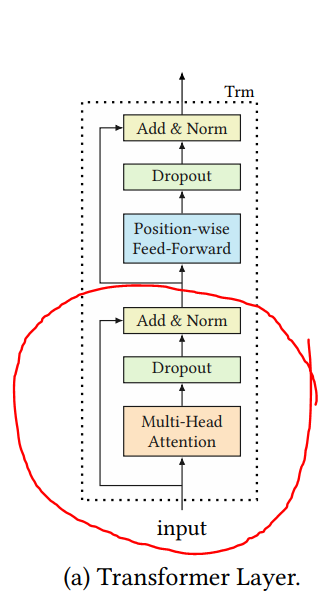

In [58]:
skip_connection = tok_pos_emb

4.1) normalization per layer:

(Batch normalization normalizes each feature independently across the mini-batch. Layer normalization normalizes each of the inputs in the batch independently across all features.)

In [59]:
tok_pos_emb_normalized = tfblock0.layernorm1(tok_pos_emb)

print(tok_pos_emb_normalized.shape)

torch.Size([128, 100, 256])


4.2) Multi-Head Attention (inside .bert4rec_modules_and_configs/models/bert_modules/attention/multi_head.py):

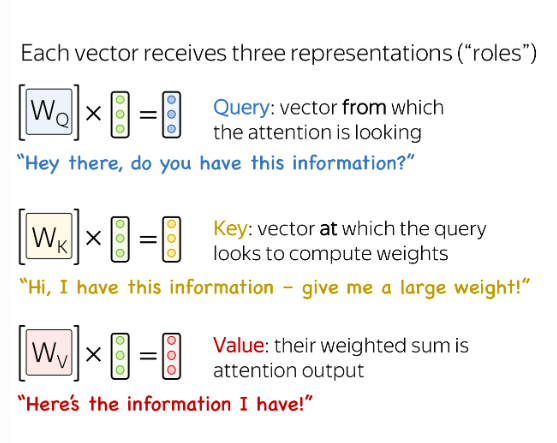

In [60]:
batch_size = tok_pos_emb_normalized.size(0) # 128
sequence_len = tok_pos_emb_normalized.size(1) # 100

In [61]:
# мб можно без этого?
query = tok_pos_emb_normalized
key = tok_pos_emb_normalized
value = tok_pos_emb_normalized

возьмем некоторые поля из инита класса MultiHeadedAttention, чтобы не описывать их вручную:

объяснить комменты ниже нормально:

In [62]:
# делаем q = emb * Wq:
Wq = tfblock0.multiheadedattention.linear_layers[0]

# вот мы его и получили - то же, что на слайде, в случае если бы мы делали только 1 голову:
Q = Wq(query)

Q.shape

torch.Size([128, 100, 256])

In [64]:
# но теперь посмотрим на Q под другими размерностями
Q_each_head = Q.view(
    batch_size, # первую размерность, которая про размер батча 128, не трогаем
    sequence_len, # вторую размерность, которая про длину последовательности 100, тоже не трогаем
    tfblock0.multiheadedattention.h, # а вот размерность эмбеда 256 разбиваем на 4...
    tfblock0.multiheadedattention.d_k # ...и на 64
)

# зачем? чтобы подготовить **для каждого токена** (во как надо понимать всё что на 3 размерности и дальше)
# по 4 эмбединга query - для каждой из голов
Q_each_head.shape

torch.Size([128, 100, 4, 64])

In [65]:
# а теперь мы хотим иметь для каждого из 128 семплов по 4 набора: последовательности длины 100, состоящие из эмбедов 64
Q_each_head = Q_each_head.transpose(1, 2)

Q_each_head.shape

torch.Size([128, 4, 100, 64])

In [66]:
# повторяем то же самое для key:
Wk = tfblock0.multiheadedattention.linear_layers[1]

K = Wk(key)

K_each_head = K.view(
    batch_size, # первую размерность, которая про размер батча 128, не трогаем
    sequence_len, # вторую размерность, которая про длину последовательности 100, тоже не трогаем
    tfblock0.multiheadedattention.h, # а вот размерность эмбеда 256 разбиваем на 4...
    tfblock0.multiheadedattention.d_k # ...и на 64
)

K_each_head = K_each_head.transpose(1, 2)

K_each_head.shape

torch.Size([128, 4, 100, 64])

In [67]:
# повторяем то же самое для value:
Wv = tfblock0.multiheadedattention.linear_layers[2]

V = Wv(value)

V_each_head = V.view(
    batch_size, # первую размерность, которая про размер батча 128, не трогаем
    sequence_len, # вторую размерность, которая про длину последовательности 100, тоже не трогаем
    tfblock0.multiheadedattention.h, # а вот размерность эмбеда 256 разбиваем на 4...
    tfblock0.multiheadedattention.d_k # ...и на 64
)

V_each_head = V_each_head.transpose(1, 2)

V_each_head.shape

torch.Size([128, 4, 100, 64])

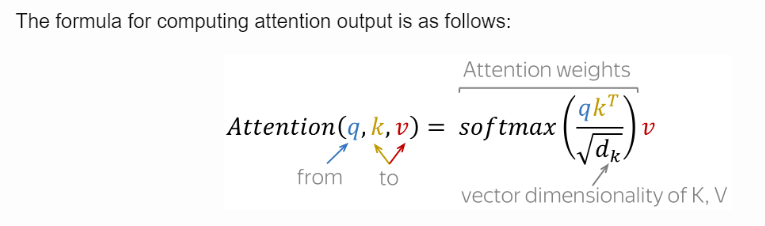

In [70]:
# объяснить
x, _ = tfblock0.multiheadedattention.attention(Q_each_head, K_each_head, V_each_head, 
                                               mask=mask, dropout=tfblock0.multiheadedattention.dropout)

print(x.shape)

torch.Size([128, 4, 100, 64])


In [71]:
# объяснить
x = x.transpose(1, 2).contiguous().view(batch_size, -1, tfblock0.multiheadedattention.h * tfblock0.multiheadedattention.d_k)

print(x.shape)

torch.Size([128, 100, 256])


In [72]:
multiheadedattention_output = tfblock0.multiheadedattention.output_linear(x)

print(x.shape)

torch.Size([128, 100, 256])


Multi-Head Attention done!

4.3) dropout

In [74]:
multiheadedattention_output_with_dropout = tfblock0.dropout1(multiheadedattention_output)

print(multiheadedattention_output_with_dropout.shape)

torch.Size([128, 100, 256])


4.4) sublayer 1 (Multi-Head Attention sublayer) done!

In [76]:
output_of_sublayer1 = multiheadedattention_output_with_dropout + skip_connection

print(output_of_sublayer1.shape)

torch.Size([128, 100, 256])


In [53]:
from bert4rec_modules_and_configs.trainers import trainer_factory

export_root = setup_train(args)

trainer = trainer_factory(args, model, train_torch_dataloader, val_torch_dataloader, test_torch_dataloader, export_root)

Folder created: C:\Users\atama\Documents\GitHub\bert4rec_ysda_seminar\seminar\experiments\test_2024-03-12_2
experiments\test_2024-03-12_2
experiments\test_2024-03-12_2\config.json

Namespace(mode='train', template=None, test_model_path=None, dataset_code='ml-1m', min_rating=0, min_uc=5, min_sc=0, split='leave_one_out', dataset_split_seed=98765, eval_set_size=500, prepared_data_path='prepared_dataset/dataset_for_bert4rec.pickle', dataloader_code='bert', dataloader_random_seed=0.0, train_batch_size=128, val_batch_size=128, test_batch_size=128, train_negative_sampler_code='random', train_negative_sample_size=0, train_negative_sampling_seed=0, test_negative_sampler_code='popular', test_negative_sample_size=100, test_negative_sampling_seed=98765, trainer_code='bert', device='cuda', num_gpu=1, device_idx='0', optimizer='Adam', lr=0.001, weight_decay=0, momentum=None, decay_step=25, gamma=1.0, num_epochs=100, log_period_as_iter=12800, metric_ks=[1, 5, 10, 20, 50, 100], best_metric='NDCG@10', 

In [54]:
trainer.train()

Val: N@1 0.007, N@5 0.028, N@10 0.045, R@1 0.007, R@5 0.050, R@10 0.102: 100%|██████████| 48/48 [00:08<00:00,  5.77it/s]
C:\Users\atama\anaconda3\envs\conda_bert4rec\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Update Best NDCG@10 Model at 1


Epoch 1, loss 7.832 : 100%|██████████| 48/48 [00:03<00:00, 14.07it/s]
Val: N@1 0.019, N@5 0.054, N@10 0.072, R@1 0.019, R@5 0.090, R@10 0.147: 100%|██████████| 48/48 [00:02<00:00, 22.20it/s]


Update Best NDCG@10 Model at 1


Epoch 2, loss 7.524 : 100%|██████████| 48/48 [00:02<00:00, 18.54it/s]
Val: N@1 0.021, N@5 0.057, N@10 0.080, R@1 0.021, R@5 0.095, R@10 0.166: 100%|██████████| 48/48 [00:02<00:00, 22.32it/s]


Update Best NDCG@10 Model at 2


Epoch 3, loss 7.380 : 100%|██████████| 48/48 [00:02<00:00, 18.66it/s] 
Val: N@1 0.033, N@5 0.083, N@10 0.111, R@1 0.033, R@5 0.132, R@10 0.222: 100%|██████████| 48/48 [00:02<00:00, 22.18it/s]


Update Best NDCG@10 Model at 3


Epoch 4, loss 7.188 : 100%|██████████| 48/48 [00:02<00:00, 18.55it/s]
Val: N@1 0.057, N@5 0.134, N@10 0.175, R@1 0.057, R@5 0.212, R@10 0.339: 100%|██████████| 48/48 [00:02<00:00, 22.12it/s]


Update Best NDCG@10 Model at 4


Epoch 5, loss 7.008 : 100%|██████████| 48/48 [00:02<00:00, 18.49it/s]  
Val: N@1 0.071, N@5 0.164, N@10 0.208, R@1 0.071, R@5 0.256, R@10 0.392: 100%|██████████| 48/48 [00:02<00:00, 21.32it/s]


Update Best NDCG@10 Model at 5


Epoch 6, loss 6.835 : 100%|██████████| 48/48 [00:02<00:00, 18.74it/s]
Val: N@1 0.094, N@5 0.199, N@10 0.242, R@1 0.094, R@5 0.303, R@10 0.437: 100%|██████████| 48/48 [00:02<00:00, 22.04it/s]


Update Best NDCG@10 Model at 6


Epoch 7, loss 6.685 : 100%|██████████| 48/48 [00:02<00:00, 18.61it/s]  
Val: N@1 0.115, N@5 0.235, N@10 0.282, R@1 0.115, R@5 0.353, R@10 0.498: 100%|██████████| 48/48 [00:02<00:00, 21.99it/s]


Update Best NDCG@10 Model at 7


Epoch 8, loss 6.572 : 100%|██████████| 48/48 [00:02<00:00, 18.70it/s]
Val: N@1 0.124, N@5 0.244, N@10 0.291, R@1 0.124, R@5 0.361, R@10 0.507: 100%|██████████| 48/48 [00:02<00:00, 21.27it/s]


Update Best NDCG@10 Model at 8


Epoch 9, loss 6.445 : 100%|██████████| 48/48 [00:02<00:00, 18.64it/s]  
Val: N@1 0.137, N@5 0.267, N@10 0.313, R@1 0.137, R@5 0.392, R@10 0.534: 100%|██████████| 48/48 [00:02<00:00, 22.24it/s]


Update Best NDCG@10 Model at 9


Epoch 10, loss 6.372 : 100%|██████████| 48/48 [00:02<00:00, 18.70it/s]
Val: N@1 0.146, N@5 0.277, N@10 0.326, R@1 0.146, R@5 0.400, R@10 0.551: 100%|██████████| 48/48 [00:02<00:00, 21.63it/s]


Update Best NDCG@10 Model at 10


Epoch 11, loss 6.285 : 100%|██████████| 48/48 [00:02<00:00, 18.69it/s] 
Val: N@1 0.160, N@5 0.296, N@10 0.344, R@1 0.160, R@5 0.425, R@10 0.572: 100%|██████████| 48/48 [00:02<00:00, 22.29it/s]


Update Best NDCG@10 Model at 11


Epoch 12, loss 6.219 : 100%|██████████| 48/48 [00:02<00:00, 18.61it/s]
Val: N@1 0.168, N@5 0.304, N@10 0.350, R@1 0.168, R@5 0.432, R@10 0.574: 100%|██████████| 48/48 [00:02<00:00, 21.97it/s]


Update Best NDCG@10 Model at 12


Epoch 13, loss 6.145 : 100%|██████████| 48/48 [00:02<00:00, 18.54it/s] 
Val: N@1 0.177, N@5 0.312, N@10 0.358, R@1 0.177, R@5 0.439, R@10 0.582: 100%|██████████| 48/48 [00:02<00:00, 22.02it/s]


Update Best NDCG@10 Model at 13


Epoch 14, loss 6.097 : 100%|██████████| 48/48 [00:02<00:00, 18.79it/s]
Val: N@1 0.182, N@5 0.327, N@10 0.372, R@1 0.182, R@5 0.462, R@10 0.599: 100%|██████████| 48/48 [00:02<00:00, 22.02it/s]


Update Best NDCG@10 Model at 14


Epoch 15, loss 6.049 : 100%|██████████| 48/48 [00:02<00:00, 18.39it/s] 
Val: N@1 0.187, N@5 0.330, N@10 0.373, R@1 0.187, R@5 0.462, R@10 0.594: 100%|██████████| 48/48 [00:02<00:00, 21.75it/s]


Update Best NDCG@10 Model at 15


Epoch 16, loss 5.991 : 100%|██████████| 48/48 [00:02<00:00, 18.44it/s]
Val: N@1 0.192, N@5 0.341, N@10 0.385, R@1 0.192, R@5 0.478, R@10 0.613: 100%|██████████| 48/48 [00:02<00:00, 21.60it/s]


Update Best NDCG@10 Model at 16


Epoch 17, loss 5.933 : 100%|██████████| 48/48 [00:02<00:00, 18.41it/s] 
Val: N@1 0.202, N@5 0.344, N@10 0.388, R@1 0.202, R@5 0.473, R@10 0.610: 100%|██████████| 48/48 [00:02<00:00, 22.05it/s]


Update Best NDCG@10 Model at 17


Epoch 18, loss 5.918 : 100%|██████████| 48/48 [00:02<00:00, 18.51it/s]
Val: N@1 0.209, N@5 0.354, N@10 0.400, R@1 0.209, R@5 0.489, R@10 0.629: 100%|██████████| 48/48 [00:02<00:00, 21.91it/s]


Update Best NDCG@10 Model at 18


Epoch 19, loss 5.877 : 100%|██████████| 48/48 [00:02<00:00, 18.68it/s]
Val: N@1 0.210, N@5 0.353, N@10 0.397, R@1 0.210, R@5 0.485, R@10 0.621: 100%|██████████| 48/48 [00:02<00:00, 21.98it/s]
Epoch 20, loss 5.836 : 100%|██████████| 48/48 [00:02<00:00, 18.63it/s]
Val: N@1 0.218, N@5 0.364, N@10 0.406, R@1 0.218, R@5 0.498, R@10 0.630: 100%|██████████| 48/48 [00:02<00:00, 22.06it/s]


Update Best NDCG@10 Model at 20


Epoch 21, loss 5.799 : 100%|██████████| 48/48 [00:02<00:00, 18.69it/s]
Val: N@1 0.212, N@5 0.361, N@10 0.403, R@1 0.212, R@5 0.499, R@10 0.629: 100%|██████████| 48/48 [00:02<00:00, 21.90it/s]
Epoch 22, loss 5.778 : 100%|██████████| 48/48 [00:02<00:00, 18.75it/s] 
Val: N@1 0.221, N@5 0.370, N@10 0.412, R@1 0.221, R@5 0.508, R@10 0.637: 100%|██████████| 48/48 [00:02<00:00, 22.00it/s]


Update Best NDCG@10 Model at 22


Epoch 23, loss 5.756 : 100%|██████████| 48/48 [00:02<00:00, 18.72it/s]
Val: N@1 0.224, N@5 0.368, N@10 0.412, R@1 0.224, R@5 0.503, R@10 0.637: 100%|██████████| 48/48 [00:02<00:00, 22.21it/s]
Epoch 24, loss 5.718 : 100%|██████████| 48/48 [00:02<00:00, 18.85it/s] 
Val: N@1 0.225, N@5 0.372, N@10 0.414, R@1 0.225, R@5 0.507, R@10 0.637: 100%|██████████| 48/48 [00:02<00:00, 21.92it/s]


Update Best NDCG@10 Model at 24


Epoch 25, loss 5.708 : 100%|██████████| 48/48 [00:02<00:00, 18.66it/s]
Val: N@1 0.229, N@5 0.373, N@10 0.416, R@1 0.229, R@5 0.506, R@10 0.640: 100%|██████████| 48/48 [00:02<00:00, 21.87it/s]


Update Best NDCG@10 Model at 25


Epoch 26, loss 5.680 : 100%|██████████| 48/48 [00:02<00:00, 18.69it/s] 
Val: N@1 0.231, N@5 0.376, N@10 0.419, R@1 0.231, R@5 0.510, R@10 0.644: 100%|██████████| 48/48 [00:02<00:00, 22.35it/s]


Update Best NDCG@10 Model at 26


Epoch 27, loss 5.641 : 100%|██████████| 48/48 [00:02<00:00, 18.58it/s]
Val: N@1 0.234, N@5 0.381, N@10 0.425, R@1 0.234, R@5 0.515, R@10 0.649: 100%|██████████| 48/48 [00:02<00:00, 22.24it/s]


Update Best NDCG@10 Model at 27


Epoch 28, loss 5.635 : 100%|██████████| 48/48 [00:02<00:00, 18.64it/s] 
Val: N@1 0.236, N@5 0.384, N@10 0.428, R@1 0.236, R@5 0.519, R@10 0.655: 100%|██████████| 48/48 [00:02<00:00, 22.15it/s]


Update Best NDCG@10 Model at 28


Epoch 29, loss 5.610 : 100%|██████████| 48/48 [00:02<00:00, 18.85it/s]
Val: N@1 0.238, N@5 0.386, N@10 0.429, R@1 0.238, R@5 0.521, R@10 0.653: 100%|██████████| 48/48 [00:02<00:00, 22.00it/s]


Update Best NDCG@10 Model at 29


Epoch 30, loss 5.591 : 100%|██████████| 48/48 [00:02<00:00, 18.88it/s] 
Val: N@1 0.245, N@5 0.389, N@10 0.432, R@1 0.245, R@5 0.524, R@10 0.657: 100%|██████████| 48/48 [00:02<00:00, 22.33it/s]


Update Best NDCG@10 Model at 30


Epoch 31, loss 5.575 : 100%|██████████| 48/48 [00:02<00:00, 18.90it/s]
Val: N@1 0.244, N@5 0.390, N@10 0.434, R@1 0.244, R@5 0.524, R@10 0.658: 100%|██████████| 48/48 [00:02<00:00, 21.67it/s]


Update Best NDCG@10 Model at 31


Epoch 32, loss 5.549 : 100%|██████████| 48/48 [00:02<00:00, 18.86it/s] 
Val: N@1 0.243, N@5 0.395, N@10 0.436, R@1 0.243, R@5 0.532, R@10 0.661: 100%|██████████| 48/48 [00:02<00:00, 22.29it/s]


Update Best NDCG@10 Model at 32


Epoch 33, loss 5.534 : 100%|██████████| 48/48 [00:02<00:00, 18.72it/s]
Val: N@1 0.242, N@5 0.389, N@10 0.432, R@1 0.242, R@5 0.526, R@10 0.656: 100%|██████████| 48/48 [00:02<00:00, 21.97it/s]
Epoch 34, loss 5.515 : 100%|██████████| 48/48 [00:02<00:00, 18.71it/s] 
Val: N@1 0.247, N@5 0.395, N@10 0.439, R@1 0.247, R@5 0.531, R@10 0.664: 100%|██████████| 48/48 [00:02<00:00, 22.25it/s]


Update Best NDCG@10 Model at 34


Epoch 35, loss 5.515 : 100%|██████████| 48/48 [00:02<00:00, 18.70it/s]
Val: N@1 0.250, N@5 0.402, N@10 0.442, R@1 0.250, R@5 0.540, R@10 0.665: 100%|██████████| 48/48 [00:02<00:00, 22.19it/s]


Update Best NDCG@10 Model at 35


Epoch 36, loss 5.482 : 100%|██████████| 48/48 [00:02<00:00, 18.81it/s]
Val: N@1 0.245, N@5 0.393, N@10 0.434, R@1 0.245, R@5 0.530, R@10 0.656: 100%|██████████| 48/48 [00:02<00:00, 21.96it/s]
Epoch 37, loss 5.469 : 100%|██████████| 48/48 [00:02<00:00, 18.81it/s]
Val: N@1 0.248, N@5 0.398, N@10 0.439, R@1 0.248, R@5 0.536, R@10 0.663: 100%|██████████| 48/48 [00:02<00:00, 21.97it/s]
Epoch 38, loss 5.451 : 100%|██████████| 48/48 [00:02<00:00, 18.43it/s]
Val: N@1 0.251, N@5 0.400, N@10 0.441, R@1 0.251, R@5 0.538, R@10 0.665: 100%|██████████| 48/48 [00:02<00:00, 21.98it/s]
Epoch 39, loss 5.448 : 100%|██████████| 48/48 [00:02<00:00, 18.71it/s]
Val: N@1 0.253, N@5 0.405, N@10 0.445, R@1 0.253, R@5 0.544, R@10 0.669: 100%|██████████| 48/48 [00:02<00:00, 22.26it/s]


Update Best NDCG@10 Model at 39


Epoch 40, loss 5.431 : 100%|██████████| 48/48 [00:02<00:00, 18.96it/s]
Val: N@1 0.257, N@5 0.411, N@10 0.453, R@1 0.257, R@5 0.553, R@10 0.681: 100%|██████████| 48/48 [00:02<00:00, 21.82it/s]


Update Best NDCG@10 Model at 40


Epoch 41, loss 5.404 : 100%|██████████| 48/48 [00:02<00:00, 18.80it/s] 
Val: N@1 0.261, N@5 0.411, N@10 0.452, R@1 0.261, R@5 0.549, R@10 0.674: 100%|██████████| 48/48 [00:02<00:00, 21.82it/s]
Epoch 42, loss 5.407 : 100%|██████████| 48/48 [00:02<00:00, 18.56it/s]
Val: N@1 0.250, N@5 0.405, N@10 0.446, R@1 0.250, R@5 0.547, R@10 0.673: 100%|██████████| 48/48 [00:02<00:00, 22.27it/s]
Epoch 43, loss 5.389 : 100%|██████████| 48/48 [00:02<00:00, 18.75it/s] 
Val: N@1 0.251, N@5 0.406, N@10 0.447, R@1 0.251, R@5 0.546, R@10 0.675: 100%|██████████| 48/48 [00:02<00:00, 22.12it/s]
Epoch 44, loss 5.384 : 100%|██████████| 48/48 [00:02<00:00, 18.51it/s]
Val: N@1 0.255, N@5 0.407, N@10 0.449, R@1 0.255, R@5 0.547, R@10 0.675: 100%|██████████| 48/48 [00:02<00:00, 22.13it/s]
Epoch 45, loss 5.353 : 100%|██████████| 48/48 [00:02<00:00, 18.64it/s] 
Val: N@1 0.258, N@5 0.412, N@10 0.451, R@1 0.258, R@5 0.553, R@10 0.673: 100%|██████████| 48/48 [00:02<00:00, 22.03it/s]
Epoch 46, loss 5.356 : 100%|█████████

Update Best NDCG@10 Model at 48


Epoch 49, loss 5.320 : 100%|██████████| 48/48 [00:02<00:00, 18.76it/s] 
Val: N@1 0.260, N@5 0.408, N@10 0.448, R@1 0.260, R@5 0.546, R@10 0.669: 100%|██████████| 48/48 [00:02<00:00, 22.17it/s]
Epoch 50, loss 5.313 : 100%|██████████| 48/48 [00:02<00:00, 18.70it/s]
Val: N@1 0.261, N@5 0.414, N@10 0.454, R@1 0.261, R@5 0.553, R@10 0.676: 100%|██████████| 48/48 [00:02<00:00, 22.09it/s]
Epoch 51, loss 5.321 : 100%|██████████| 48/48 [00:02<00:00, 18.83it/s] 
Val: N@1 0.262, N@5 0.412, N@10 0.454, R@1 0.262, R@5 0.550, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 21.68it/s]
Epoch 52, loss 5.289 : 100%|██████████| 48/48 [00:02<00:00, 18.66it/s]
Val: N@1 0.261, N@5 0.413, N@10 0.454, R@1 0.261, R@5 0.552, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 22.19it/s]
Logging to Tensorboard: 100%|██████████| 48/48 [00:02<00:00, 18.57it/s]
Val: N@1 0.269, N@5 0.421, N@10 0.461, R@1 0.269, R@5 0.562, R@10 0.684: 100%|██████████| 48/48 [00:02<00:00, 22.11it/s]


Update Best NDCG@10 Model at 53


Epoch 54, loss 5.275 : 100%|██████████| 48/48 [00:02<00:00, 18.66it/s]
Val: N@1 0.261, N@5 0.414, N@10 0.453, R@1 0.261, R@5 0.554, R@10 0.675: 100%|██████████| 48/48 [00:02<00:00, 22.17it/s]
Epoch 55, loss 5.249 : 100%|██████████| 48/48 [00:02<00:00, 18.53it/s]
Val: N@1 0.259, N@5 0.415, N@10 0.455, R@1 0.259, R@5 0.558, R@10 0.680: 100%|██████████| 48/48 [00:02<00:00, 21.82it/s]
Epoch 56, loss 5.256 : 100%|██████████| 48/48 [00:02<00:00, 18.65it/s]
Val: N@1 0.266, N@5 0.422, N@10 0.461, R@1 0.266, R@5 0.566, R@10 0.686: 100%|██████████| 48/48 [00:02<00:00, 21.67it/s]


Update Best NDCG@10 Model at 56


Epoch 57, loss 5.266 : 100%|██████████| 48/48 [00:02<00:00, 18.53it/s]
Val: N@1 0.264, N@5 0.417, N@10 0.454, R@1 0.264, R@5 0.558, R@10 0.672: 100%|██████████| 48/48 [00:02<00:00, 22.20it/s]
Epoch 58, loss 5.242 : 100%|██████████| 48/48 [00:02<00:00, 18.50it/s] 
Val: N@1 0.267, N@5 0.419, N@10 0.458, R@1 0.267, R@5 0.559, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 21.86it/s]
Epoch 59, loss 5.238 : 100%|██████████| 48/48 [00:02<00:00, 18.78it/s]
Val: N@1 0.266, N@5 0.414, N@10 0.455, R@1 0.266, R@5 0.548, R@10 0.675: 100%|██████████| 48/48 [00:02<00:00, 21.95it/s]
Epoch 60, loss 5.234 : 100%|██████████| 48/48 [00:02<00:00, 18.73it/s] 
Val: N@1 0.260, N@5 0.414, N@10 0.453, R@1 0.260, R@5 0.556, R@10 0.676: 100%|██████████| 48/48 [00:02<00:00, 21.93it/s]
Epoch 61, loss 5.218 : 100%|██████████| 48/48 [00:02<00:00, 18.55it/s]
Val: N@1 0.269, N@5 0.417, N@10 0.456, R@1 0.269, R@5 0.553, R@10 0.674: 100%|██████████| 48/48 [00:02<00:00, 21.50it/s]
Epoch 62, loss 5.213 : 100%|██████████

Update Best NDCG@10 Model at 68


Epoch 69, loss 5.171 : 100%|██████████| 48/48 [00:02<00:00, 18.70it/s]
Val: N@1 0.265, N@5 0.419, N@10 0.460, R@1 0.265, R@5 0.557, R@10 0.684: 100%|██████████| 48/48 [00:02<00:00, 21.69it/s]
Epoch 70, loss 5.151 : 100%|██████████| 48/48 [00:02<00:00, 18.60it/s] 
Val: N@1 0.269, N@5 0.421, N@10 0.461, R@1 0.269, R@5 0.560, R@10 0.683: 100%|██████████| 48/48 [00:02<00:00, 22.13it/s]
Epoch 71, loss 5.148 : 100%|██████████| 48/48 [00:02<00:00, 18.76it/s]
Val: N@1 0.263, N@5 0.417, N@10 0.457, R@1 0.263, R@5 0.557, R@10 0.682: 100%|██████████| 48/48 [00:02<00:00, 21.70it/s]
Epoch 72, loss 5.139 : 100%|██████████| 48/48 [00:02<00:00, 18.62it/s]
Val: N@1 0.271, N@5 0.423, N@10 0.464, R@1 0.271, R@5 0.562, R@10 0.687: 100%|██████████| 48/48 [00:02<00:00, 22.26it/s]


Update Best NDCG@10 Model at 72


Epoch 73, loss 5.130 : 100%|██████████| 48/48 [00:02<00:00, 18.60it/s]
Val: N@1 0.265, N@5 0.420, N@10 0.459, R@1 0.265, R@5 0.562, R@10 0.681: 100%|██████████| 48/48 [00:02<00:00, 21.76it/s]
Epoch 74, loss 5.112 : 100%|██████████| 48/48 [00:02<00:00, 18.72it/s]
Val: N@1 0.268, N@5 0.422, N@10 0.459, R@1 0.268, R@5 0.563, R@10 0.677: 100%|██████████| 48/48 [00:02<00:00, 21.56it/s]
Epoch 75, loss 5.117 : 100%|██████████| 48/48 [00:02<00:00, 18.39it/s]
Val: N@1 0.276, N@5 0.426, N@10 0.465, R@1 0.276, R@5 0.564, R@10 0.683: 100%|██████████| 48/48 [00:02<00:00, 22.18it/s]


Update Best NDCG@10 Model at 75


Epoch 76, loss 5.109 : 100%|██████████| 48/48 [00:02<00:00, 18.66it/s]
Val: N@1 0.271, N@5 0.427, N@10 0.464, R@1 0.271, R@5 0.569, R@10 0.684: 100%|██████████| 48/48 [00:02<00:00, 22.12it/s]
Epoch 77, loss 5.091 : 100%|██████████| 48/48 [00:02<00:00, 18.66it/s] 
Val: N@1 0.264, N@5 0.415, N@10 0.452, R@1 0.264, R@5 0.553, R@10 0.669: 100%|██████████| 48/48 [00:02<00:00, 22.25it/s]
Epoch 78, loss 5.087 : 100%|██████████| 48/48 [00:02<00:00, 18.80it/s]
Val: N@1 0.266, N@5 0.419, N@10 0.461, R@1 0.266, R@5 0.557, R@10 0.683: 100%|██████████| 48/48 [00:02<00:00, 22.01it/s]
Epoch 79, loss 5.093 : 100%|██████████| 48/48 [00:02<00:00, 18.64it/s] 
Val: N@1 0.269, N@5 0.424, N@10 0.461, R@1 0.269, R@5 0.564, R@10 0.677: 100%|██████████| 48/48 [00:02<00:00, 21.99it/s]
Epoch 80, loss 5.086 : 100%|██████████| 48/48 [00:02<00:00, 18.62it/s]
Val: N@1 0.270, N@5 0.422, N@10 0.461, R@1 0.270, R@5 0.560, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 21.92it/s]
Epoch 81, loss 5.067 : 100%|██████████

Update Best NDCG@10 Model at 86


Epoch 87, loss 5.034 : 100%|██████████| 48/48 [00:02<00:00, 18.85it/s] 
Val: N@1 0.272, N@5 0.422, N@10 0.461, R@1 0.272, R@5 0.560, R@10 0.681: 100%|██████████| 48/48 [00:02<00:00, 22.18it/s]
Epoch 88, loss 5.049 : 100%|██████████| 48/48 [00:02<00:00, 18.45it/s]
Val: N@1 0.266, N@5 0.420, N@10 0.457, R@1 0.266, R@5 0.560, R@10 0.674: 100%|██████████| 48/48 [00:02<00:00, 22.15it/s]
Epoch 89, loss 5.034 : 100%|██████████| 48/48 [00:02<00:00, 18.62it/s]
Val: N@1 0.268, N@5 0.421, N@10 0.461, R@1 0.268, R@5 0.559, R@10 0.682: 100%|██████████| 48/48 [00:02<00:00, 22.12it/s]
Epoch 90, loss 5.030 : 100%|██████████| 48/48 [00:02<00:00, 18.87it/s]
Val: N@1 0.269, N@5 0.419, N@10 0.459, R@1 0.269, R@5 0.554, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 22.09it/s]
Epoch 91, loss 5.028 : 100%|██████████| 48/48 [00:02<00:00, 18.58it/s]
Val: N@1 0.262, N@5 0.416, N@10 0.456, R@1 0.262, R@5 0.555, R@10 0.677: 100%|██████████| 48/48 [00:02<00:00, 21.79it/s]
Epoch 92, loss 5.010 : 100%|██████████|

In [55]:
trainer.test()

Test best model with test set!


Val: N@1 0.222, N@5 0.363, N@10 0.399, R@1 0.222, R@5 0.491, R@10 0.603: 100%|██████████| 48/48 [00:02<00:00, 19.21it/s]


{'Recall@100': 0.9970703125, 'NDCG@100': 0.4793995910634597, 'Recall@50': 0.8744032122194767, 'NDCG@50': 0.459500656152765, 'Recall@20': 0.7215711809694767, 'NDCG@20': 0.42913077399134636, 'Recall@10': 0.6033528645833334, 'NDCG@10': 0.3991682343184948, 'Recall@5': 0.4912651913861434, 'NDCG@5': 0.3627896886318922, 'Recall@1': 0.22211371548473835, 'NDCG@1': 0.22211371548473835}


old, recheck reproducibility:

In [56]:
trainer.train()

Val: N@1 0.007, N@5 0.028, N@10 0.045, R@1 0.007, R@5 0.050, R@10 0.102: 100%|██████████| 48/48 [00:05<00:00,  9.57it/s]
C:\Users\atama\anaconda3\envs\conda_bert4rec\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Update Best NDCG@10 Model at 1


Epoch 1, loss 7.829 : 100%|██████████| 48/48 [00:02<00:00, 17.95it/s]
Val: N@1 0.021, N@5 0.052, N@10 0.074, R@1 0.021, R@5 0.084, R@10 0.154: 100%|██████████| 48/48 [00:02<00:00, 22.47it/s]


Update Best NDCG@10 Model at 1


Epoch 2, loss 7.526 : 100%|██████████| 48/48 [00:02<00:00, 18.91it/s]
Val: N@1 0.025, N@5 0.066, N@10 0.089, R@1 0.025, R@5 0.107, R@10 0.180: 100%|██████████| 48/48 [00:02<00:00, 22.52it/s]


Update Best NDCG@10 Model at 2


Epoch 3, loss 7.369 : 100%|██████████| 48/48 [00:02<00:00, 18.76it/s] 
Val: N@1 0.038, N@5 0.094, N@10 0.125, R@1 0.038, R@5 0.150, R@10 0.248: 100%|██████████| 48/48 [00:02<00:00, 22.51it/s]


Update Best NDCG@10 Model at 3


Epoch 4, loss 7.182 : 100%|██████████| 48/48 [00:02<00:00, 18.83it/s]
Val: N@1 0.053, N@5 0.122, N@10 0.160, R@1 0.053, R@5 0.193, R@10 0.312: 100%|██████████| 48/48 [00:02<00:00, 22.24it/s]


Update Best NDCG@10 Model at 4


Epoch 5, loss 6.986 : 100%|██████████| 48/48 [00:02<00:00, 18.89it/s]  
Val: N@1 0.070, N@5 0.163, N@10 0.204, R@1 0.070, R@5 0.255, R@10 0.383: 100%|██████████| 48/48 [00:02<00:00, 22.28it/s]


Update Best NDCG@10 Model at 5


Epoch 6, loss 6.835 : 100%|██████████| 48/48 [00:02<00:00, 18.85it/s]
Val: N@1 0.095, N@5 0.203, N@10 0.249, R@1 0.095, R@5 0.306, R@10 0.450: 100%|██████████| 48/48 [00:02<00:00, 22.60it/s]


Update Best NDCG@10 Model at 6


Epoch 7, loss 6.678 : 100%|██████████| 48/48 [00:02<00:00, 18.72it/s]  
Val: N@1 0.108, N@5 0.228, N@10 0.277, R@1 0.108, R@5 0.342, R@10 0.494: 100%|██████████| 48/48 [00:02<00:00, 21.63it/s]


Update Best NDCG@10 Model at 7


Epoch 8, loss 6.564 : 100%|██████████| 48/48 [00:02<00:00, 18.65it/s]
Val: N@1 0.125, N@5 0.243, N@10 0.288, R@1 0.125, R@5 0.357, R@10 0.497: 100%|██████████| 48/48 [00:02<00:00, 22.32it/s]


Update Best NDCG@10 Model at 8


Epoch 9, loss 6.443 : 100%|██████████| 48/48 [00:02<00:00, 18.71it/s]  
Val: N@1 0.142, N@5 0.269, N@10 0.317, R@1 0.142, R@5 0.390, R@10 0.539: 100%|██████████| 48/48 [00:02<00:00, 22.44it/s]


Update Best NDCG@10 Model at 9


Epoch 10, loss 6.359 : 100%|██████████| 48/48 [00:02<00:00, 18.73it/s]
Val: N@1 0.149, N@5 0.282, N@10 0.327, R@1 0.149, R@5 0.409, R@10 0.550: 100%|██████████| 48/48 [00:02<00:00, 22.46it/s]


Update Best NDCG@10 Model at 10


Epoch 11, loss 6.285 : 100%|██████████| 48/48 [00:02<00:00, 18.80it/s] 
Val: N@1 0.151, N@5 0.283, N@10 0.329, R@1 0.151, R@5 0.408, R@10 0.548: 100%|██████████| 48/48 [00:02<00:00, 22.46it/s]


Update Best NDCG@10 Model at 11


Epoch 12, loss 6.206 : 100%|██████████| 48/48 [00:02<00:00, 18.79it/s]
Val: N@1 0.174, N@5 0.310, N@10 0.356, R@1 0.174, R@5 0.438, R@10 0.578: 100%|██████████| 48/48 [00:02<00:00, 22.53it/s]


Update Best NDCG@10 Model at 12


Epoch 13, loss 6.142 : 100%|██████████| 48/48 [00:02<00:00, 18.74it/s] 
Val: N@1 0.173, N@5 0.312, N@10 0.357, R@1 0.173, R@5 0.443, R@10 0.581: 100%|██████████| 48/48 [00:02<00:00, 22.42it/s]


Update Best NDCG@10 Model at 13


Epoch 14, loss 6.098 : 100%|██████████| 48/48 [00:02<00:00, 18.70it/s]
Val: N@1 0.176, N@5 0.314, N@10 0.360, R@1 0.176, R@5 0.442, R@10 0.585: 100%|██████████| 48/48 [00:02<00:00, 22.28it/s]


Update Best NDCG@10 Model at 14


Epoch 15, loss 6.040 : 100%|██████████| 48/48 [00:02<00:00, 18.76it/s] 
Val: N@1 0.192, N@5 0.328, N@10 0.374, R@1 0.192, R@5 0.452, R@10 0.593: 100%|██████████| 48/48 [00:02<00:00, 22.32it/s]


Update Best NDCG@10 Model at 15


Epoch 16, loss 5.996 : 100%|██████████| 48/48 [00:02<00:00, 18.79it/s]
Val: N@1 0.192, N@5 0.339, N@10 0.382, R@1 0.192, R@5 0.474, R@10 0.609: 100%|██████████| 48/48 [00:02<00:00, 22.22it/s]


Update Best NDCG@10 Model at 16


Epoch 17, loss 5.969 : 100%|██████████| 48/48 [00:02<00:00, 18.76it/s] 
Val: N@1 0.191, N@5 0.338, N@10 0.382, R@1 0.191, R@5 0.475, R@10 0.611: 100%|██████████| 48/48 [00:02<00:00, 22.04it/s]


Update Best NDCG@10 Model at 17


Epoch 18, loss 5.921 : 100%|██████████| 48/48 [00:02<00:00, 19.01it/s]
Val: N@1 0.201, N@5 0.348, N@10 0.392, R@1 0.201, R@5 0.484, R@10 0.619: 100%|██████████| 48/48 [00:02<00:00, 22.24it/s]


Update Best NDCG@10 Model at 18


Epoch 19, loss 5.867 : 100%|██████████| 48/48 [00:02<00:00, 18.97it/s]
Val: N@1 0.211, N@5 0.360, N@10 0.401, R@1 0.211, R@5 0.497, R@10 0.626: 100%|██████████| 48/48 [00:02<00:00, 22.50it/s]


Update Best NDCG@10 Model at 19


Epoch 20, loss 5.853 : 100%|██████████| 48/48 [00:02<00:00, 18.87it/s]
Val: N@1 0.206, N@5 0.356, N@10 0.399, R@1 0.206, R@5 0.493, R@10 0.625: 100%|██████████| 48/48 [00:02<00:00, 22.32it/s]
Epoch 21, loss 5.814 : 100%|██████████| 48/48 [00:02<00:00, 18.60it/s]
Val: N@1 0.216, N@5 0.366, N@10 0.411, R@1 0.216, R@5 0.504, R@10 0.640: 100%|██████████| 48/48 [00:02<00:00, 21.98it/s]


Update Best NDCG@10 Model at 21


Epoch 22, loss 5.775 : 100%|██████████| 48/48 [00:02<00:00, 18.49it/s] 
Val: N@1 0.218, N@5 0.368, N@10 0.410, R@1 0.218, R@5 0.506, R@10 0.635: 100%|██████████| 48/48 [00:02<00:00, 21.78it/s]
Epoch 23, loss 5.755 : 100%|██████████| 48/48 [00:02<00:00, 18.91it/s]
Val: N@1 0.216, N@5 0.362, N@10 0.406, R@1 0.216, R@5 0.496, R@10 0.631: 100%|██████████| 48/48 [00:02<00:00, 22.29it/s]
Epoch 24, loss 5.730 : 100%|██████████| 48/48 [00:02<00:00, 18.76it/s] 
Val: N@1 0.223, N@5 0.371, N@10 0.412, R@1 0.223, R@5 0.507, R@10 0.634: 100%|██████████| 48/48 [00:02<00:00, 21.86it/s]


Update Best NDCG@10 Model at 24


Epoch 25, loss 5.693 : 100%|██████████| 48/48 [00:02<00:00, 18.45it/s]
Val: N@1 0.223, N@5 0.375, N@10 0.417, R@1 0.223, R@5 0.514, R@10 0.645: 100%|██████████| 48/48 [00:02<00:00, 21.04it/s]


Update Best NDCG@10 Model at 25


Epoch 26, loss 5.681 : 100%|██████████| 48/48 [00:02<00:00, 18.86it/s] 
Val: N@1 0.223, N@5 0.375, N@10 0.418, R@1 0.223, R@5 0.514, R@10 0.644: 100%|██████████| 48/48 [00:02<00:00, 22.27it/s]


Update Best NDCG@10 Model at 26


Epoch 27, loss 5.651 : 100%|██████████| 48/48 [00:02<00:00, 18.78it/s]
Val: N@1 0.230, N@5 0.383, N@10 0.427, R@1 0.230, R@5 0.521, R@10 0.656: 100%|██████████| 48/48 [00:02<00:00, 21.95it/s]


Update Best NDCG@10 Model at 27


Epoch 28, loss 5.645 : 100%|██████████| 48/48 [00:02<00:00, 18.82it/s] 
Val: N@1 0.232, N@5 0.387, N@10 0.428, R@1 0.232, R@5 0.530, R@10 0.656: 100%|██████████| 48/48 [00:02<00:00, 22.08it/s]


Update Best NDCG@10 Model at 28


Epoch 29, loss 5.616 : 100%|██████████| 48/48 [00:02<00:00, 19.03it/s]
Val: N@1 0.239, N@5 0.387, N@10 0.427, R@1 0.239, R@5 0.524, R@10 0.647: 100%|██████████| 48/48 [00:02<00:00, 22.20it/s]
Epoch 30, loss 5.593 : 100%|██████████| 48/48 [00:02<00:00, 18.81it/s] 
Val: N@1 0.238, N@5 0.389, N@10 0.431, R@1 0.238, R@5 0.527, R@10 0.657: 100%|██████████| 48/48 [00:02<00:00, 22.28it/s]


Update Best NDCG@10 Model at 30


Epoch 31, loss 5.566 : 100%|██████████| 48/48 [00:02<00:00, 18.66it/s]
Val: N@1 0.245, N@5 0.392, N@10 0.433, R@1 0.245, R@5 0.526, R@10 0.653: 100%|██████████| 48/48 [00:02<00:00, 21.82it/s]


Update Best NDCG@10 Model at 31


Epoch 32, loss 5.556 : 100%|██████████| 48/48 [00:02<00:00, 18.82it/s] 
Val: N@1 0.236, N@5 0.389, N@10 0.429, R@1 0.236, R@5 0.527, R@10 0.650: 100%|██████████| 48/48 [00:02<00:00, 22.31it/s]
Epoch 33, loss 5.546 : 100%|██████████| 48/48 [00:02<00:00, 18.63it/s]
Val: N@1 0.248, N@5 0.400, N@10 0.442, R@1 0.248, R@5 0.536, R@10 0.666: 100%|██████████| 48/48 [00:02<00:00, 21.87it/s]


Update Best NDCG@10 Model at 33


Epoch 34, loss 5.522 : 100%|██████████| 48/48 [00:02<00:00, 18.79it/s] 
Val: N@1 0.239, N@5 0.392, N@10 0.433, R@1 0.239, R@5 0.532, R@10 0.659: 100%|██████████| 48/48 [00:02<00:00, 22.04it/s]
Epoch 35, loss 5.502 : 100%|██████████| 48/48 [00:02<00:00, 18.88it/s]
Val: N@1 0.251, N@5 0.403, N@10 0.443, R@1 0.251, R@5 0.540, R@10 0.665: 100%|██████████| 48/48 [00:02<00:00, 21.10it/s]


Update Best NDCG@10 Model at 35


Epoch 36, loss 5.489 : 100%|██████████| 48/48 [00:02<00:00, 18.22it/s]
Val: N@1 0.247, N@5 0.402, N@10 0.442, R@1 0.247, R@5 0.542, R@10 0.665: 100%|██████████| 48/48 [00:02<00:00, 21.45it/s]
Epoch 37, loss 5.481 : 100%|██████████| 48/48 [00:02<00:00, 18.79it/s]
Val: N@1 0.247, N@5 0.398, N@10 0.440, R@1 0.247, R@5 0.532, R@10 0.663: 100%|██████████| 48/48 [00:02<00:00, 20.75it/s]
Epoch 38, loss 5.456 : 100%|██████████| 48/48 [00:02<00:00, 18.46it/s]
Val: N@1 0.242, N@5 0.399, N@10 0.440, R@1 0.242, R@5 0.542, R@10 0.668: 100%|██████████| 48/48 [00:02<00:00, 22.21it/s]
Epoch 39, loss 5.456 : 100%|██████████| 48/48 [00:02<00:00, 18.98it/s]
Val: N@1 0.251, N@5 0.403, N@10 0.444, R@1 0.251, R@5 0.542, R@10 0.668: 100%|██████████| 48/48 [00:02<00:00, 21.95it/s]


Update Best NDCG@10 Model at 39


Epoch 40, loss 5.429 : 100%|██████████| 48/48 [00:02<00:00, 18.88it/s]
Val: N@1 0.249, N@5 0.406, N@10 0.445, R@1 0.249, R@5 0.549, R@10 0.671: 100%|██████████| 48/48 [00:02<00:00, 22.10it/s]


Update Best NDCG@10 Model at 40


Epoch 41, loss 5.439 : 100%|██████████| 48/48 [00:02<00:00, 18.71it/s] 
Val: N@1 0.250, N@5 0.404, N@10 0.444, R@1 0.250, R@5 0.544, R@10 0.667: 100%|██████████| 48/48 [00:02<00:00, 22.29it/s]
Epoch 42, loss 5.432 : 100%|██████████| 48/48 [00:02<00:00, 18.98it/s]
Val: N@1 0.251, N@5 0.399, N@10 0.443, R@1 0.251, R@5 0.535, R@10 0.669: 100%|██████████| 48/48 [00:02<00:00, 21.75it/s]
Epoch 43, loss 5.399 : 100%|██████████| 48/48 [00:02<00:00, 18.89it/s] 
Val: N@1 0.253, N@5 0.405, N@10 0.449, R@1 0.253, R@5 0.542, R@10 0.678: 100%|██████████| 48/48 [00:02<00:00, 21.98it/s]


Update Best NDCG@10 Model at 43


Epoch 44, loss 5.395 : 100%|██████████| 48/48 [00:02<00:00, 18.60it/s]
Val: N@1 0.247, N@5 0.400, N@10 0.444, R@1 0.247, R@5 0.540, R@10 0.678: 100%|██████████| 48/48 [00:02<00:00, 22.10it/s]
Epoch 45, loss 5.384 : 100%|██████████| 48/48 [00:02<00:00, 18.92it/s] 
Val: N@1 0.255, N@5 0.406, N@10 0.450, R@1 0.255, R@5 0.543, R@10 0.676: 100%|██████████| 48/48 [00:02<00:00, 22.11it/s]


Update Best NDCG@10 Model at 45


Epoch 46, loss 5.370 : 100%|██████████| 48/48 [00:02<00:00, 18.72it/s]
Val: N@1 0.260, N@5 0.413, N@10 0.454, R@1 0.260, R@5 0.551, R@10 0.680: 100%|██████████| 48/48 [00:02<00:00, 22.04it/s]


Update Best NDCG@10 Model at 46


Epoch 47, loss 5.361 : 100%|██████████| 48/48 [00:02<00:00, 18.77it/s] 
Val: N@1 0.256, N@5 0.409, N@10 0.450, R@1 0.256, R@5 0.548, R@10 0.675: 100%|██████████| 48/48 [00:02<00:00, 21.84it/s]
Epoch 48, loss 5.355 : 100%|██████████| 48/48 [00:02<00:00, 19.00it/s]
Val: N@1 0.266, N@5 0.418, N@10 0.458, R@1 0.266, R@5 0.558, R@10 0.682: 100%|██████████| 48/48 [00:02<00:00, 21.95it/s]


Update Best NDCG@10 Model at 48


Epoch 49, loss 5.330 : 100%|██████████| 48/48 [00:02<00:00, 18.49it/s] 
Val: N@1 0.262, N@5 0.410, N@10 0.453, R@1 0.262, R@5 0.545, R@10 0.675: 100%|██████████| 48/48 [00:02<00:00, 22.07it/s]
Epoch 50, loss 5.329 : 100%|██████████| 48/48 [00:02<00:00, 18.42it/s]
Val: N@1 0.264, N@5 0.414, N@10 0.455, R@1 0.264, R@5 0.548, R@10 0.673: 100%|██████████| 48/48 [00:02<00:00, 21.95it/s]
Epoch 51, loss 5.312 : 100%|██████████| 48/48 [00:02<00:00, 18.69it/s] 
Val: N@1 0.254, N@5 0.404, N@10 0.448, R@1 0.254, R@5 0.539, R@10 0.674: 100%|██████████| 48/48 [00:02<00:00, 22.03it/s]
Epoch 52, loss 5.312 : 100%|██████████| 48/48 [00:02<00:00, 18.51it/s]
Val: N@1 0.259, N@5 0.409, N@10 0.449, R@1 0.259, R@5 0.542, R@10 0.668: 100%|██████████| 48/48 [00:02<00:00, 21.87it/s]
Logging to Tensorboard: 100%|██████████| 48/48 [00:02<00:00, 18.74it/s]
Val: N@1 0.260, N@5 0.411, N@10 0.452, R@1 0.260, R@5 0.549, R@10 0.675: 100%|██████████| 48/48 [00:02<00:00, 22.03it/s]
Epoch 54, loss 5.289 : 100%|█████████

Update Best NDCG@10 Model at 62


Epoch 63, loss 5.202 : 100%|██████████| 48/48 [00:02<00:00, 18.82it/s]
Val: N@1 0.261, N@5 0.410, N@10 0.451, R@1 0.261, R@5 0.546, R@10 0.672: 100%|██████████| 48/48 [00:02<00:00, 22.29it/s]
Epoch 64, loss 5.183 : 100%|██████████| 48/48 [00:02<00:00, 18.88it/s] 
Val: N@1 0.257, N@5 0.408, N@10 0.449, R@1 0.257, R@5 0.545, R@10 0.674: 100%|██████████| 48/48 [00:02<00:00, 22.04it/s]
Epoch 65, loss 5.204 : 100%|██████████| 48/48 [00:02<00:00, 18.72it/s]
Val: N@1 0.260, N@5 0.413, N@10 0.453, R@1 0.260, R@5 0.553, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 22.38it/s]
Epoch 66, loss 5.173 : 100%|██████████| 48/48 [00:02<00:00, 18.55it/s] 
Val: N@1 0.262, N@5 0.415, N@10 0.456, R@1 0.262, R@5 0.553, R@10 0.680: 100%|██████████| 48/48 [00:02<00:00, 21.98it/s]
Epoch 67, loss 5.171 : 100%|██████████| 48/48 [00:02<00:00, 18.89it/s]
Val: N@1 0.264, N@5 0.412, N@10 0.453, R@1 0.264, R@5 0.549, R@10 0.673: 100%|██████████| 48/48 [00:02<00:00, 21.29it/s]
Epoch 68, loss 5.188 : 100%|██████████

Update Best NDCG@10 Model at 75


Epoch 76, loss 5.125 : 100%|██████████| 48/48 [00:02<00:00, 18.70it/s]
Val: N@1 0.267, N@5 0.415, N@10 0.453, R@1 0.267, R@5 0.547, R@10 0.665: 100%|██████████| 48/48 [00:02<00:00, 22.02it/s]
Epoch 77, loss 5.117 : 100%|██████████| 48/48 [00:02<00:00, 18.89it/s] 
Val: N@1 0.264, N@5 0.415, N@10 0.454, R@1 0.264, R@5 0.553, R@10 0.670: 100%|██████████| 48/48 [00:02<00:00, 21.87it/s]
Epoch 78, loss 5.095 : 100%|██████████| 48/48 [00:02<00:00, 18.72it/s]
Val: N@1 0.267, N@5 0.419, N@10 0.459, R@1 0.267, R@5 0.555, R@10 0.678: 100%|██████████| 48/48 [00:02<00:00, 22.18it/s]
Epoch 79, loss 5.104 : 100%|██████████| 48/48 [00:02<00:00, 18.75it/s] 
Val: N@1 0.262, N@5 0.416, N@10 0.455, R@1 0.262, R@5 0.558, R@10 0.678: 100%|██████████| 48/48 [00:02<00:00, 21.91it/s]
Epoch 80, loss 5.089 : 100%|██████████| 48/48 [00:02<00:00, 18.22it/s]
Val: N@1 0.273, N@5 0.424, N@10 0.462, R@1 0.273, R@5 0.561, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 21.44it/s]
Epoch 81, loss 5.088 : 100%|██████████

Update Best NDCG@10 Model at 84


Epoch 85, loss 5.056 : 100%|██████████| 48/48 [00:02<00:00, 18.75it/s] 
Val: N@1 0.262, N@5 0.418, N@10 0.456, R@1 0.262, R@5 0.558, R@10 0.677: 100%|██████████| 48/48 [00:02<00:00, 22.17it/s]
Epoch 86, loss 5.055 : 100%|██████████| 48/48 [00:02<00:00, 18.59it/s]
Val: N@1 0.268, N@5 0.422, N@10 0.461, R@1 0.268, R@5 0.561, R@10 0.680: 100%|██████████| 48/48 [00:02<00:00, 21.40it/s]
Epoch 87, loss 5.057 : 100%|██████████| 48/48 [00:02<00:00, 18.67it/s] 
Val: N@1 0.268, N@5 0.420, N@10 0.461, R@1 0.268, R@5 0.558, R@10 0.684: 100%|██████████| 48/48 [00:02<00:00, 21.52it/s]
Epoch 88, loss 5.049 : 100%|██████████| 48/48 [00:02<00:00, 18.68it/s]
Val: N@1 0.271, N@5 0.423, N@10 0.462, R@1 0.271, R@5 0.560, R@10 0.681: 100%|██████████| 48/48 [00:02<00:00, 22.24it/s]
Epoch 89, loss 5.041 : 100%|██████████| 48/48 [00:02<00:00, 18.76it/s]
Val: N@1 0.269, N@5 0.418, N@10 0.456, R@1 0.269, R@5 0.554, R@10 0.672: 100%|██████████| 48/48 [00:02<00:00, 22.05it/s]
Epoch 90, loss 5.046 : 100%|██████████

In [57]:
trainer.test()

Test best model with test set!


Val: N@1 0.215, N@5 0.356, N@10 0.395, R@1 0.215, R@5 0.486, R@10 0.605: 100%|██████████| 48/48 [00:02<00:00, 19.79it/s]

{'Recall@100': 0.9970703125, 'NDCG@100': 0.47501263581216335, 'Recall@50': 0.8770073788861433, 'NDCG@50': 0.4555890740205844, 'Recall@20': 0.7222764765222868, 'NDCG@20': 0.42481197354694206, 'Recall@10': 0.60498046875, 'NDCG@10': 0.3951025288552046, 'Recall@5': 0.4856228306889534, 'NDCG@5': 0.35642762916783494, 'Recall@1': 0.2152235247194767, 'NDCG@1': 0.2152235247194767}


---

посчитаем ndcg@10 как в бейзлайнах - по датафрейму neg_sampled_test и по той функции рассчёта, которая использовалась там:

In [56]:
best_model = torch.load(os.path.join(export_root, 'models', 'best_acc_model.pth')).get('model_state_dict')

In [57]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [58]:
model.eval()

BERTModel(
  (bert): BERT(
    (embedding): BERTEmbedding(
      (token): TokenEmbedding(3708, 256, padding_idx=0)
      (position): PositionalEmbedding(
        (pe): Embedding(100, 256)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_blocks): ModuleList(
      (0): TransformerBlock(
        (layernorm1): LayerNorm()
        (multiheadedattention): MultiHeadedAttention(
          (linear_layers): ModuleList(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): Linear(in_features=256, out_features=256, bias=True)
            (2): Linear(in_features=256, out_features=256, bias=True)
          )
          (output_linear): Linear(in_features=256, out_features=256, bias=True)
          (attention): Attention()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (layernorm2): LayerNorm()
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in

In [59]:
from tqdm import tqdm

# получаем предикты для mask_token на тестовой последовательности:
scores_for_mask_token_for_each_batch = []

with torch.no_grad():
    tqdm_dataloader = tqdm(test_torch_dataloader)
    
    for batch_idx, batch in enumerate(tqdm_dataloader):
        batch = [x.to('cuda') for x in batch]
        
        scores = model(batch[0])
        scores_for_mask_token = scores[:, -1, :]
        
        scores_for_mask_token_for_each_batch.append(scores_for_mask_token.cpu())

100%|██████████| 48/48 [00:01<00:00, 41.66it/s]


In [60]:
scores_for_mask_token = torch.cat(scores_for_mask_token_for_each_batch, dim=0)

scores_for_mask_token.shape

torch.Size([6040, 3707])

In [61]:
user_to_scores_of_items = dict()

for user_ix, scores in enumerate(scores_for_mask_token):
    user_to_scores_of_items[user_ix] = dict()
    
    for item_ix, score in enumerate(scores):
        user_to_scores_of_items[user_ix][item_ix] = score.item()

In [62]:
# отслеживаем путь юзера с индексом 0 (оригинальный айди 1)
print(
    user_to_scores_of_items[0][49], # видел на трейне
    user_to_scores_of_items[0][50], # видел на трейне
    user_to_scores_of_items[0][51], # не видел на трейне (а стоило бы вернуть - мы его украли в валидационное взаимодействие)
    user_to_scores_of_items[0][52], # не видел на трейне
    user_to_scores_of_items[0][53], # не видел на трейне (и в реальности его не было в train + val + test)
    user_to_scores_of_items[0][54], # не видел на трейне (и в реальности его не было в train + val + test)
)

8.800130844116211 9.801734924316406 10.547264099121094 9.773677825927734 2.118375062942505 2.109822988510132


выглядит правдоподобно

In [65]:
from metrics import *

In [66]:
def calculate_grouped_ndcg_for_bert4rec_output(valDf, model_scores, k):
    data = valDf.copy()
    
    data["predicted_rating"] = data.apply(lambda row: model_scores[row["user_id"]][row["movie_id"]], axis=1)
    
    nonnull_users = set(data[data.rating > 0].user_id)
    data = data[data.user_id.isin(nonnull_users)]
    
    return np.mean(data.groupby("user_id").apply(lambda x: ndcg_score(x.rating, x.predicted_rating, k)))

In [67]:
calculate_grouped_ndcg_for_bert4rec_output(neg_sampled_test, user_to_scores_of_items, 10)

0.39689939838386823